# $\underline{\textbf{Digits recognition : a Kaggle challenge}}$

## $\textbf{Bastien Zimmermann}$                        
$\textit{last modification : ??/??/????}$

---
# Introduction
$\\\text{This notebook is an attempt to solve the famous Kaggle Challenge : Digit Recognition with scikit learn dataset hand written dataset}$
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

$\text{Computer vision has applications in a lot a fields and is in itself a complex, intricate and worderfully interesting problem.}$

$\text{The task allows to set up for fundamentals of CNN (convolutional neural networks) through the use of a clean and easy dataset.}\\\textit{Thank you scikit-learn!}$

---

First off let's just import libraries that we will need and load the data.

### $\textbf{Import libraries :}$

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from skimage.transform import resize


from tqdm import tqdm

### $\textbf{Load Data}$

In [5]:
trainDF = pd.read_csv('./train.csv')
#test = pd.read_csv('./test.csv')


$\underline{\text{First off let's have a look at our dataset}}$

In [92]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [91]:
trainDF.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


$\text{The pictures are encoded pixel by pixel, we can easily gather them in arrays and pyplot works well around those.}$

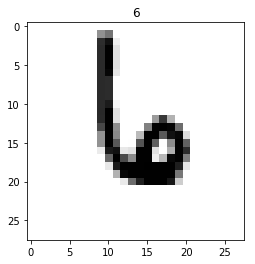

In [88]:
def showImage( index):
    '''
        A little function to check the label visually.
    '''
    image = trainDF.iloc[index][1:].values.reshape(28,28)
    plt.imshow(image,cmap='Greys')
    plt.title(trainDF['label'].iloc[index])
showImage(123)

An example of the digits we can find :


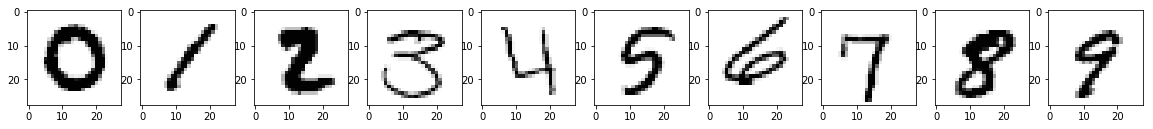

In [87]:
fig, ax = plt.subplots(ncols = 10,nrows =1, figsize = [20,5])
print('An example of the digits we can find :')
for i in range(10):
    image = trainDF[trainDF['label']==i].iloc[0][1:].values.reshape(28,28)
    ax[i].imshow(image,cmap='Greys',label=str(i))

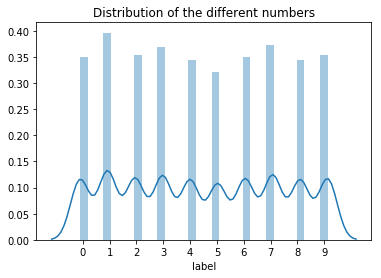

In [134]:
sns.distplot(trainDF['label'])
plt.title('Distribution of the different numbers')
plt.xticks([x*0.975+0.1 for x in range(10)],[x for x in range(10)],rotation = 'horizontal')
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)


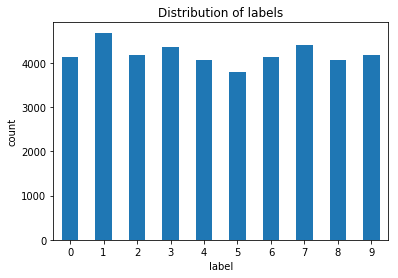

In [101]:
trainDF.groupby('label').count()['pixel0'].plot(x='label',kind = 'bar')
plt.ylabel('count')
plt.xticks(rotation = 'horizontal')
plt.title('Distribution of labels')
print(plt.xticks())
plt.show()

$\text{It is notable that there is a sufficient number of each number in the dataset, however the 5 is less frequent.}$

In [8]:
#check for nan values 
trainDF.isnull().sum().sum()

0

$\text{The dataset is clean}$

### $\text{Define the function useful in our model}$

In [9]:
#define the rectified linear unit function
relu = lambda x: (x+abs(x))/2

#convolve(data, kernel)
def convolution_layer(image, filt):
    temp = convolve(image, filt)
    filtered = relu(temp)
    return (temp, filtered)

def convolved(image,kernel):
    return(convolve(image,kernel))

def maxPooling(image, size = 2):#problem with layer limits
    res = skimage.measure.block_reduce(image, (size,size), np.max)
    return(res)

def softmax(x):
    e_x = np.exp(x)
    return (e_x / sum(e_x))

def lossFunc(x, label):#categorical cross entropy loss (softmax + cross entropy)
    return (-np.sum(label * np.log(x)))



def convolution(image, filt, bias, s=1):
    '''
    Confolves `filt` over `image` using stride `s`
    '''
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
    # ensure that the filter dimensions match the dimensions of the input image
    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    
    out = np.zeros((n_f,out_dim,out_dim)) # create the matrix to hold the values of the convolution operation
    
    # convolve each filter over the image
    for curr_f in range(n_f):
        curr_y = out_y = 0
        # move filter vertically across the image
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            # move filter horizontally across the image 
            while curr_x + f <= in_dim:
                # perform the convolution operation and add the bias
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return out

def maxpool(image, f=2, s=2):
    '''
    Downsample input `image` using a kernel size of `f` and a stride of `s`
    '''
    n_c, h_prev, w_prev = image.shape
    
    # calculate output dimensions after the maxpooling operation.
    h = int((h_prev - f)/s)+1 
    w = int((w_prev - f)/s)+1
    
    # create a matrix to hold the values of the maxpooling operation.
    downsampled = np.zeros((n_c, h, w)) 
    
    # slide the window over every part of the image using stride s. Take the maximum value at each step.
    for i in range(n_c):
        curr_y = out_y = 0
        # slide the max pooling window vertically across the image
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            # slide the max pooling window horizontally across the image
            while curr_x + f <= w_prev:
                # choose the maximum value within the window at each step and store it to the output matrix
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled

In [10]:
def initializeFilter(size, scale = 1.0):
    '''
    Initialize filter using a normal distribution with and a 
    standard deviation inversely proportional the square root of the number of units
    '''
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    '''
    Initialize weights with a random normal distribution
    '''
    return np.random.standard_normal(size=size) * 0.01

###  $\text{Define backward }$

In [11]:
#adapted and modified from https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1
def convolutionBackward(dconv_prev, conv_in, filt, s):
    '''
    Backpropagation through a convolutional layer. 
    '''
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias


def maxpoolBackward(dpool, orig, f = 2, s = 2):
    '''
    Backpropagation through a maxpooling layer. The gradients are passed through the indices of greatest value in the original maxpooling during the forward step.
    '''
    (n_c, orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                arr = orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f]
                (a, b) = np.unravel_index(np.nanargmax(arr), arr.shape)
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout

### $\text{Forward + backward}$

$\text{}$

In [12]:
#adapted and modified from https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1
#modified
def conv(image, label, params, conv_s, pool_f, pool_s):
    
    [f1, f2, w1, w2, b1, b2, b3, b4] = params 
    
    ################################################
    ############## Forward Operation ###############
    ################################################
    #convolve + relu first one
    conv1 = convolution(image, f1, b1, conv_s)#convolve(image, f1)
    conv1 = relu(conv1)

    pooled1 = maxpool(conv1, pool_f, pool_s)
    (nf2, dim2, _) = pooled1.shape
    flatpool1 = pooled1.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer

     #convolve + relu second one
    conv2 = convolution(pooled1, f2, b2, conv_s)#convolve(conv1, f1)
    conv2 = relu(conv2)

    pooled2 = maxpool(conv2, pool_f, pool_s)#maxPooling(conv2, size = 2)#pool_f, pool_s ???

    (nf2, dim2, _) = pooled2.shape
    flatpool2 = pooled2.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer

    hidden = relu(w1.dot(flatpool2) + b3) # first dense layer + relu

    out = w2.dot(hidden) + b4 # second dense layer

    probs = softmax(out) # predict class probabilities with the softmax activation function


    ################################################
    #################### Loss ######################
    ################################################
    loss = 0
    loss = lossFunc(probs, label) # categorical cross-entropy loss

    ################################################
    ############# Backward Operation ###############
    ################################################
    #NN -> pool2 -> conv2 -> pool1 -> conv1
    dout = probs - label # derivative of loss w.r.t. final dense layer output
    dw2 = dout.dot(hidden.T) # loss gradient of final dense layer weights
    db4 = np.sum(dout, axis = 1).reshape(b4.shape) # loss gradient of final dense layer biases

    dhidden = relu(w2.T.dot(dout)) # loss gradient of first dense layer outputs + relu

    dw1 = dhidden.dot(flatpool2.T)
    db3 = np.sum(dhidden, axis = 1).reshape(b3.shape)

    dfc2 = w1.T.dot(dhidden) # loss gradients of fully-connected layer (pooling layer)
    dpool2 = dfc2.reshape(pooled2.shape) # reshape fully connected into dimensions of pooling layer

    dconv2 = maxpoolBackward(dpool2, conv2, pool_f, pool_s) # backprop through the max-pooling layer(only neurons with highest activation in window get updated)
    dconv2 = relu(dconv2) # backpropagate through ReLU

    #---que rajoute-t-on ici ?????????????
    dpool1, df2, db2 = convolutionBackward(dconv2, pooled1, f2, conv_s)
    #dpool1= relu(dpool1) # backpropagate through ReLU ->not necessary ?????????
    #dpool1, df1,df3 = #??convolutionBackward(dconv2, pooled1, f2, conv_s)
    #dpool2 = dfc.reshape(pooled.shape)

    dconv1 = maxpoolBackward(dpool1, conv1, pool_f, pool_s) 
    dconv1= relu(dconv1) # backpropagate through ReLU

    dimage, df1, db1 = convolutionBackward(dconv1, image, f1, conv_s) # backpropagate previous gradient through first convolutional layer.

    grads = [df1, df2, dw1, dw2, db1, db2, db3, db4] 
    
    return grads, loss

In [13]:
#i will try another thing before (a more classic approach ?)
def adamGD(batch, num_classes, lr, dim, n_c, beta1, beta2, params, cost):
    '''
    update the parameters through Adam gradient descnet.
    '''
    [f1, f2, w3, w4, b1, b2, b3, b4] = params
    
    X = batch[:,0:-1] # get batch inputs
    #print(type(batch),type(dim),type(n_c))
    #print('dim',dim,type(dim))
    X = X.reshape(len(batch), n_c, dim, dim)
    Y = batch[:,-1] # get batch labels
    
    cost_ = 0
    batch_size = len(batch)
    
    # initialize gradients and momentum,RMS params
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw3 = np.zeros(w3.shape)
    dw4 = np.zeros(w4.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)
    
    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w3.shape)
    v4 = np.zeros(w4.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)
    
    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w3.shape)
    s4 = np.zeros(w4.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)
    
    for i in range(batch_size):
        
        x = X[i]
        y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot
        
        # Collect Gradients for training example
        grads, loss = conv(x, y, params, 1, 2, 2)
        [df1_, df2_, dw3_, dw4_, db1_, db2_, db3_, db4_] = grads
        
        df1+=df1_
        db1+=db1_
        df2+=df2_
        db2+=db2_
        dw3+=dw3_
        db3+=db3_
        dw4+=dw4_
        db4+=db4_

        cost_+= loss

    # Parameter Update  
        
    v1 = beta1*v1 + (1-beta1)*df1/batch_size # momentum update
    s1 = beta2*s1 + (1-beta2)*(df1/batch_size)**2 # RMSProp update
    f1 -= lr * v1/np.sqrt(s1+1e-7) # combine momentum and RMSProp to perform update with Adam
    
    bv1 = beta1*bv1 + (1-beta1)*db1/batch_size
    bs1 = beta2*bs1 + (1-beta2)*(db1/batch_size)**2
    b1 -= lr * bv1/np.sqrt(bs1+1e-7)
   
    v2 = beta1*v2 + (1-beta1)*df2/batch_size
    s2 = beta2*s2 + (1-beta2)*(df2/batch_size)**2
    f2 -= lr * v2/np.sqrt(s2+1e-7)
                       
    bv2 = beta1*bv2 + (1-beta1) * db2/batch_size
    bs2 = beta2*bs2 + (1-beta2)*(db2/batch_size)**2
    b2 -= lr * bv2/np.sqrt(bs2+1e-7)
    
    v3 = beta1*v3 + (1-beta1) * dw3/batch_size
    s3 = beta2*s3 + (1-beta2)*(dw3/batch_size)**2
    w3 -= lr * v3/np.sqrt(s3+1e-7)
    
    bv3 = beta1*bv3 + (1-beta1) * db3/batch_size
    bs3 = beta2*bs3 + (1-beta2)*(db3/batch_size)**2
    b3 -= lr * bv3/np.sqrt(bs3+1e-7)
    
    v4 = beta1*v4 + (1-beta1) * dw4/batch_size
    s4 = beta2*s4 + (1-beta2)*(dw4/batch_size)**2
    w4 -= lr * v4 / np.sqrt(s4+1e-7)
    
    bv4 = beta1*bv4 + (1-beta1)*db4/batch_size
    bs4 = beta2*bs4 + (1-beta2)*(db4/batch_size)**2
    b4 -= lr * bv4 / np.sqrt(bs4+1e-7)
    
    
    cost_ = cost_/batch_size
    cost.append(cost_)

    params = [f1, f2, w3, w4, b1, b2, b3, b4]
    
    return params, cost

In [14]:
def train(train_data, params, num_classes = 10, lr = 0.01, beta1 = 0.95,
          beta2 = 0.99, img_dim = 28, img_depth = 1, f = 5, num_filt1 = 8,
          num_filt2 = 8, batch_size = 32, num_epochs = 2):

    
    np.random.shuffle(train_data)#shuffle the training data

    cost = []

    print("LR:"+str(lr)+", Batch Size:"+str(batch_size))

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]

        t = tqdm(batches)
        for x,batch in enumerate(t):
            params, cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, cost)
            t.set_description("Cost: %.2f" % (cost[-1]))
            
    final_params = params
    
    return final_params, cost

In [15]:
num_out_neurons = trainDF['label'].nunique()
def initialize(X, y,num_filt1 = 8, img_depth = 1, f=5, num_filt2 = 8, num_hidden_neurons = 16):
    #w1 = (num hiden neuron, num input neurons)
    #w2 = (num out neuron, num hiden neuron)
    f1, f2, w1, w2 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (num_hidden_neurons,128), (num_out_neurons, num_hidden_neurons)
    f1 = initializeFilter(f1)
    f2 = initializeFilter(f2)
    w1 = initializeWeight(w1)
    w2 = initializeWeight(w2)
    
    b1 = np.zeros((f1.shape[0],1))
    b2 = np.zeros((f2.shape[0],1))
    b3 = np.zeros((w1.shape[0],1))
    b4 = np.zeros((w2.shape[0],1))

    params = [f1, f2, w1, w2, b1, b2, b3, b4]

    #prepare the training data
    y_dash = y_train.reshape(len(y_train),1)
    
    #print(np.shape(y_dash),np.shape(X))
    train_data = np.hstack((X,y_dash))
    
    return (train_data, params)

In [28]:
#trainDF['image'] = trainDF.drop(columns=['label']).apply(lambda x : x['pixel0'])#resize(x[1].values.reshape(28,28),(10,10)))

In [49]:
42000/2

21000.0

In [53]:
miniTrainDF = trainDF.truncate(32000)
print(np.shape(miniTrainDF))
np.shape(trainDF)

(10000, 785)


(42000, 785)

In [54]:
y_train = miniTrainDF['label'].values
x_train = miniTrainDF.drop(columns = ['label'])
#x_train.head(1)

In [55]:
%%time
#Initialize the parameters
train_data, params = initialize(x_train,y_train)#initialize on the training set

CPU times: user 28.9 ms, sys: 12.2 ms, total: 41.1 ms
Wall time: 101 ms


### $\underline{\textbf{Model Training}}$

<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

In [ ]:
#train
final_params, cost = train(train_data = train_data, params = params, num_classes = trainDF['label'].nunique(),
                           lr = 0.01, beta1 = 0.95, beta2 = 0.99,
                           img_dim = 28, img_depth = 1, f = 5, num_filt1 = 8,
                           num_filt2 = 8, batch_size = 32, num_epochs = 2)

LR:0.01, Batch Size:32


Cost: 2.32:  48%|████▊     | 149/313 [24:17<33:35, 12.29s/it] 